In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC, LinearSVC

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

## Exploratory data analysis
in this section we check the datashape, missing values as well as correlations between survivability with other variables

In [346]:
# Check datashape and missing values
train_df
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

,Survived
Sex,
female,0.742038
male,0.188908


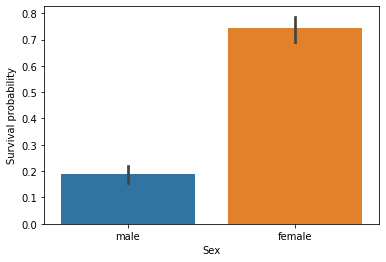

In [347]:
#Check correlation between survival and Sex
g = sns.barplot(x='Sex', y='Survived', data=train_df)
g = g.set_ylabel('Survival probability')

train_df[['Sex','Survived']].groupby('Sex').mean()

#### Survivability vs. Pclass

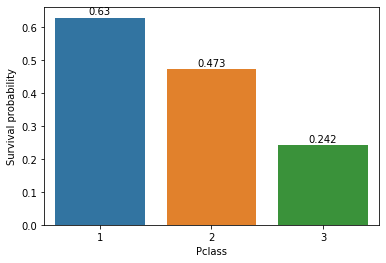

In [348]:
g = sns.barplot(x='Pclass', y='Survived', data=train_df, ci = None)

# put values on the bars
for i in g.patches:
    height = i.get_height()
    g.text(i.get_x() + i.get_width()/2, 0.01 + height, round(i.get_height(),3), color="black", ha="center")

g = g.set_ylabel('Survival probability')
# plt.savefig('plots/survival vs. pclass.png')
plt.show()

#### Survivability vs. SibSp

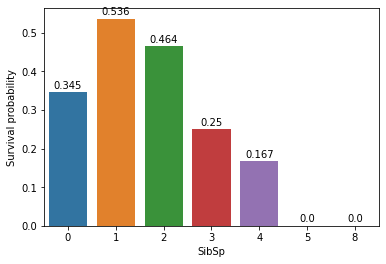

In [349]:
g = sns.barplot(x='SibSp', y='Survived', data=train_df, ci = None)

# put values on the bars
for i in g.patches:
    height = i.get_height()
    g.text(i.get_x() + i.get_width()/2, 0.01 + height, round(i.get_height(),3), color="black", ha="center")

g = g.set_ylabel('Survival probability')
#plt.savefig('plots/survival vs. sibsp.png', bbox_inches = "tight")
plt.show()

#### Survivability vs. ParCh

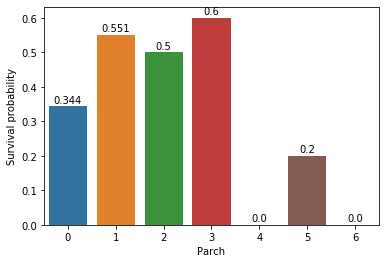

In [350]:
g = sns.barplot(x='Parch', y='Survived', data=train_df, ci = None)

# put values on the bars
for i in g.patches:
    height = i.get_height()
    g.text(i.get_x() + i.get_width()/2, 0.01 + height, round(i.get_height(),3), color="black", ha="center")

g = g.set_ylabel('Survival probability')
plt.show()

#### Survivability vs. Fare

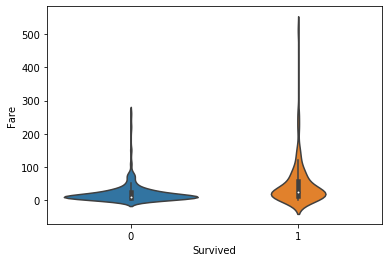

In [351]:
#Check correlation between survival and Fare
g = sns.violinplot(x = 'Survived', y='Fare', data=train_df)
g = g.set_ylabel('Fare')
plt.show()

## Feature engineering
* Missing values Age: Make a correlation heatmap/factorplot of the variable Age with other variables
* Extract Title from Name. Impute missing values from median age grouped by Sex, Pclass and Title, FamilySize
* Missing values Embarked: Fill with S
* Missing values Cabin: Fill missing with U from Unknown
* Make FamilySize. Single, small, med, large

### Survivability vs. Ticket
By extracting ticket prefixes (returns X if prefix is not available)

In [3]:
train_df['Ticket'].head() 

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

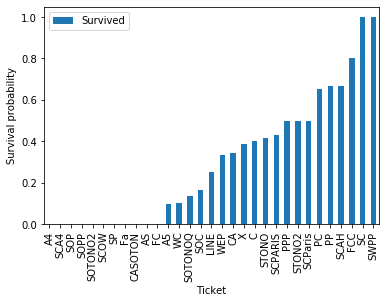

In [39]:
train = train_df.copy()
test = test_df.copy()
data = [train, test]

for dataset in data:
    Ticket = []
    for i in list(dataset.Ticket):
        if not i.isdigit():
            Ticket.append(i.replace(".","").replace("/","").strip().split(" ")[0])
        else:
            Ticket.append("X")
    dataset["Ticket"] = Ticket
    
train.groupby('Ticket').mean()[['Survived']].sort_values(by = ['Survived']).plot(kind = 'bar')
plt.ylabel('Survival probability')
plt.show()
# train_df.loc[train_df['Ticket']=='FC']

Check Ticket vs. Pclass

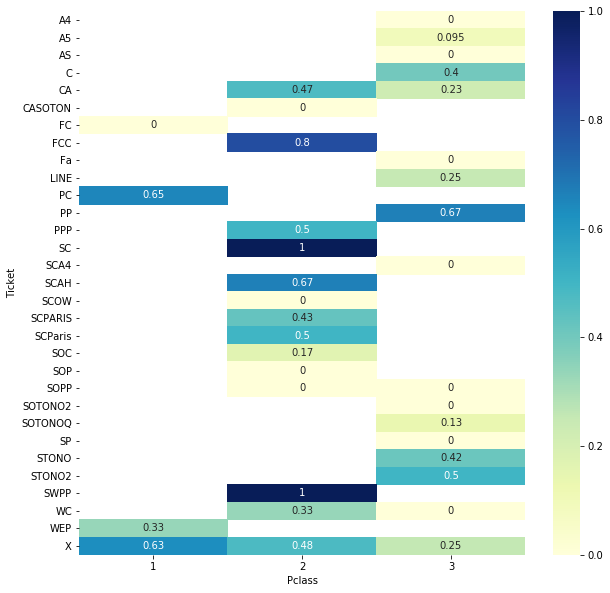

In [40]:
hm_tp = pd.pivot_table(train, values='Survived', index=['Ticket'], columns='Pclass')
plt.figure(figsize=(10,10))
sns.heatmap(hm_tp, annot=True, cmap="YlGnBu")

### Survivability vs. Embarked

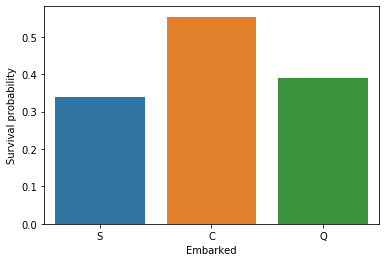

In [41]:
train['Embarked'] = train['Embarked'].fillna('S')  
train['Embarked'].isnull().sum()

g = sns.barplot(x='Embarked', y='Survived', data=train, ci=None)
g = g.set_ylabel('Survival probability')
plt.show()

### Survivability vs. Cabin
By imputing missing values with U from Unknown

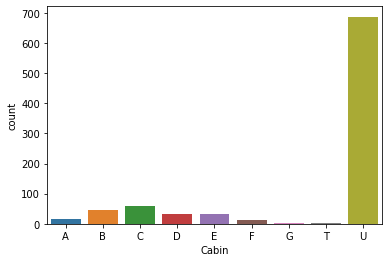

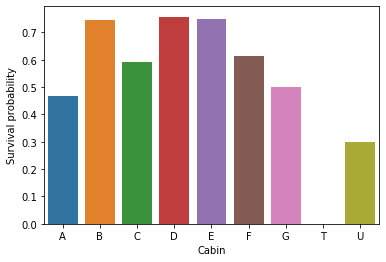

In [42]:
train['Cabin'] = train['Cabin'].fillna('U') 

# Assign each cabin value with its first cabin letter
train['Cabin'] = train['Cabin'].map(lambda c: c[0])  

g = sns.countplot(train["Cabin"],order=['A','B','C','D','E','F','G','T','U'])
plt.show()

h = sns.barplot(x='Cabin', y='Survived', data=train, order=['A','B','C','D','E','F','G','T','U'], ci=None)
h = h.set_ylabel('Survival probability')
plt.show()

### Fill missing values in Age
By checking first the correlation between the the variable with the other ones

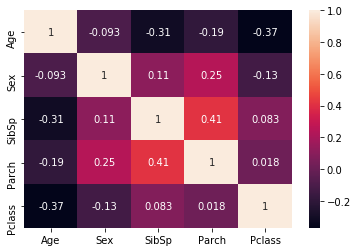

In [43]:
train["Sex"] = train["Sex"].map({"male": 0, "female":1})
g = sns.heatmap(train[["Age","Sex","SibSp","Parch","Pclass"]].corr(),annot=True)
plt.show()

Fill the missing values Age with median age based on high correlated variables: SibSp, Parch and Pclass

/Users/restria.hertomo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/restria.hertomo/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


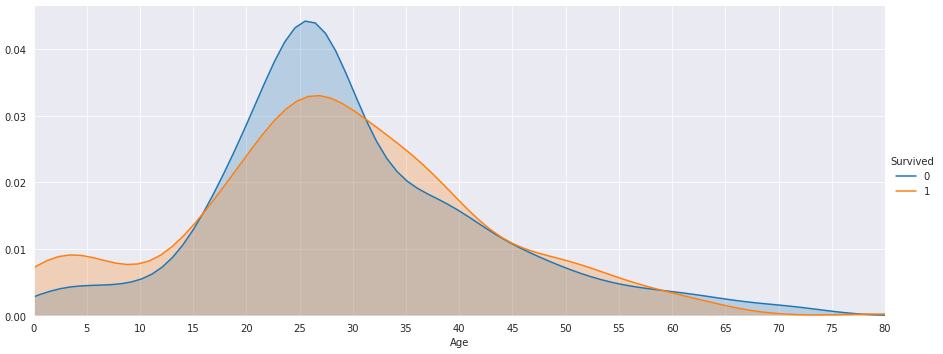

In [44]:
index_missing_age = list(train['Age'][train['Age'].isnull()].index)

for i in index_missing_age:
    median_age = train['Age'].median()
    pred_age = train['Age'][((train['SibSp'] == train.iloc[i]['SibSp']) & (train['Parch'] == train.iloc[i]['Parch']) & (train['Pclass'] == train.iloc[i]['Pclass']))].median()
    if not np.isnan(pred_age):
        train['Age'].iloc[i] = pred_age
    else:
        train['Age'].iloc[i] = median_age     

# df1 = pd.DataFrame(train_df[['Age','SibSp', 'Parch', 'Pclass']])
with sns.axes_style("darkgrid"):
    g = sns.FacetGrid(train, hue='Survived', height=5, aspect=2.5)
    g.map(sns.kdeplot, 'Age', shade=True)
    g.add_legend()
    g.set(xticks=np.arange(0, train['Age'].max() + 1, 5), xlim=(0, train_df['Age'].max()))

Bin age roughly according to the distribution above and making each bin roughly the same size

In [45]:
for dataset in data:
    # dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 23), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 23) & (dataset['Age'] <= 26), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 32), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 44), 'Age'] = 4   
    dataset.loc[(dataset['Age'] > 44), 'Age'] = 5
 
# train['Age'].value_counts().sort_index(ascending=True)
# # age_groups = data["Age"]
# train_df['AgeGroup'] = train['Age']
# test_df['AgeGroup'] = test['Age']

### Make new column "Title" from names

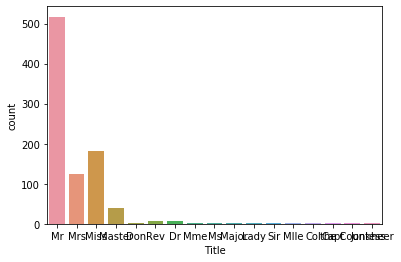

<Figure size 1080x720 with 0 Axes>

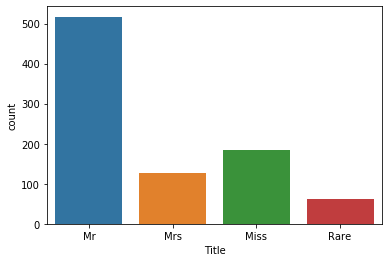

In [46]:
# dataset = pd.concat([train, test], sort=False).drop(columns='Survived')

for dataset in data:    
    titles = [] 
    for i in list(dataset['Name']):
         titles.append(i.split(',')[1].split('.')[0].strip())
    dataset['Title'] = titles     

g = sns.countplot(x='Title', data=train)
# plt.rcParams['figure.figsize']=(15,5)
# plt.tick_params(axis= 'x', labelsize = 8)
plt.figure(figsize=(15,10))
plt.show()

# train_df['Title'].head() 
# train_df['Title'].value_counts() 
# train_df['Title'].nunique() 

# Group Mlle and Ms together with Miss as well as Mme with Mrs and the upper class people together
for dataset in data: 
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms'],'Miss')
    dataset['Title'] = dataset['Title'].replace(['Mme'],'Mrs')
    
# Cluster other categories with low frequency
for dataset in data: 
    dataset['Title'] = dataset['Title'].replace(['Master', 'Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 
                                               'the Countess', 'Jonkheer'], 'Rare')  
g = sns.countplot(x='Title', data=train)
plt.show()

# train_df['Title'] = train['Title']
# test_df['Title'] = test['Title']

Put fare into groups

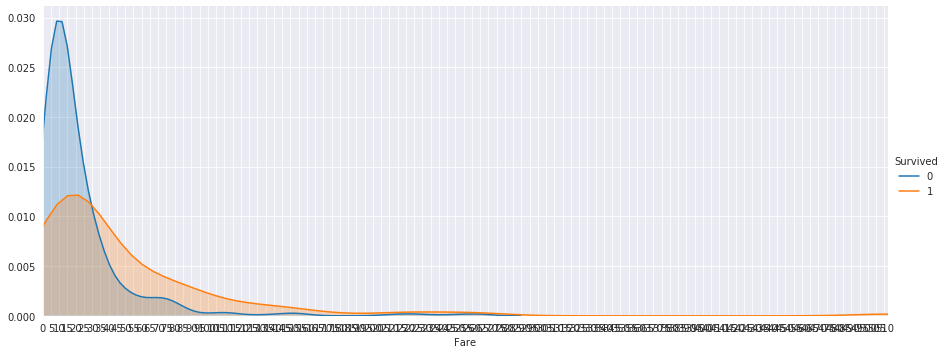

In [48]:
with sns.axes_style("darkgrid"):
    g = sns.FacetGrid(train, hue='Survived', height=5, aspect=2.5)
    g.map(sns.kdeplot, 'Fare', shade=True)
    g.add_legend()
    g.set(xticks=np.arange(0, train['Fare'].max() + 1, 5), xlim=(0, train['Fare'].max()))

There are 248 unique Fare values. We can bin them.

In [57]:
for dataset in data:
    dataset['qbin_Fare'] = pd.qcut(dataset['Fare'], q=5)
    
train['qbin_Fare'].value_counts()

(7.854, 10.5]        184
(21.679, 39.688]     180
(-0.001, 7.854]      179
(39.688, 512.329]    176
(10.5, 21.679]       172
Name: qbin_Fare, dtype: int64

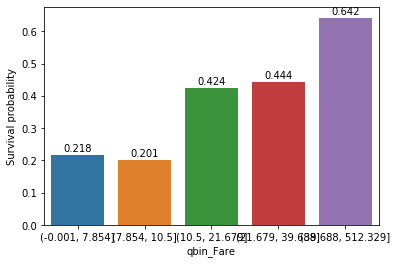

<Figure size 2160x1440 with 0 Axes>

In [56]:
g = sns.barplot(x='qbin_Fare', y='Survived', data=train, ci = None)

# put values on the bars
for i in g.patches:
    height = i.get_height()
    g.text(i.get_x() + i.get_width()/2, 0.01 + height, round(i.get_height(),3), color="black", ha="center")

g = g.set_ylabel('Survival probability')
plt.figure(figsize=(30,20))
plt.show()

In [62]:
train

,Survived,Pclass,Age,SibSp,Parch,Ticket,Cabin,Embarked,Title,qbin_Fare
0,0,3,1.0,1,0,A5,U,S,Mr,"(-0.001, 7.854]"
1,1,1,4.0,1,0,PC,C,C,Mrs,"(39.688, 512.329]"
2,1,3,2.0,0,0,STONO2,U,S,Miss,"(7.854, 10.5]"
3,1,1,4.0,1,0,X,C,S,Mrs,"(39.688, 512.329]"
4,0,3,4.0,0,0,X,U,S,Mr,"(7.854, 10.5]"
...,...,...,...,...,...,...,...,...,...,...
886,0,2,3.0,0,0,X,U,S,Rare,"(10.5, 21.679]"
887,1,1,1.0,0,0,X,B,S,Miss,"(21.679, 39.688]"
888,0,3,0.0,1,2,WC,U,S,Miss,"(21.679, 39.688]"
889,1,1,2.0,0,0,X,C,C,Mr,"(21.679, 39.688]"


In [47]:
train.drop(columns=['Name', 'Sex', 'PassengerId', 'Fare'], inplace=True)
test.drop(columns=['Name', 'Sex', 'PassengerId', 'Fare'], inplace=True)

## Build classifier

Encode, split, scale

In [63]:
# rel_data = df[model_vars]
# rel_data_encoded = pd.get_dummies(rel_data) 

train

,Survived,Pclass,Age,SibSp,Parch,Ticket,Cabin,Embarked,Title,qbin_Fare
0,0,3,1.0,1,0,A5,U,S,Mr,"(-0.001, 7.854]"
1,1,1,4.0,1,0,PC,C,C,Mrs,"(39.688, 512.329]"
2,1,3,2.0,0,0,STONO2,U,S,Miss,"(7.854, 10.5]"
3,1,1,4.0,1,0,X,C,S,Mrs,"(39.688, 512.329]"
4,0,3,4.0,0,0,X,U,S,Mr,"(7.854, 10.5]"
...,...,...,...,...,...,...,...,...,...,...
886,0,2,3.0,0,0,X,U,S,Rare,"(10.5, 21.679]"
887,1,1,1.0,0,0,X,B,S,Miss,"(21.679, 39.688]"
888,0,3,0.0,1,2,WC,U,S,Miss,"(21.679, 39.688]"
889,1,1,2.0,0,0,X,C,C,Mr,"(21.679, 39.688]"


In [68]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]

X_test  = test

# # Scale features such that the mean is 0 and standard deviation is 
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

Apply decision tree, RF and logistic regression on these train dataset as they can accept categorical variables.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


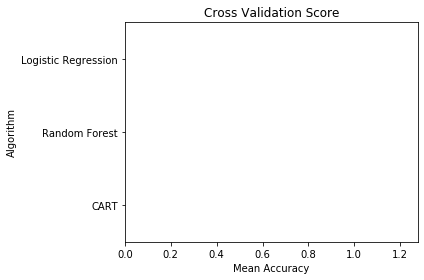

In [70]:
random_state = 1        # Fixate a random state so that the results are reproducible
n_jobs = -1

logreg = LogisticRegression(random_state=random_state)
rf = RandomForestClassifier(random_state=random_state)
cart = DecisionTreeClassifier(random_state=random_state)

clf = []        # List of algorithms
clf.append(logreg)
clf.append(rf)
clf.append(cart)


kfold = StratifiedKFold(n_splits=5)
cross_val_results = []      # Returns n-fold results of cross validation of each predictor
for classifier in clf:
    cv_score = cross_val_score(classifier, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    cross_val_results.append(cv_score)

cv_means = []    # Returns the means of the n-fold cross val results
cv_std = []      # Returns the standard deviation of the n-fold cross val results
for cv in cross_val_results:
    cv_means.append(cv.mean())
    cv_std.append(cv.std())   

cv_res = pd.DataFrame({"Cross Val Means":cv_means, "Cross Val Errors":cv_std, "Algorithm":["Logistic Regression", "Random Forest", "CART"]})

order = cv_res.sort_values('Cross Val Means')      # Order bars in ascending order
g = sns.barplot("Cross Val Means","Algorithm",data = cv_res, order=order['Algorithm'], palette="Set3",orient = "h", **{'xerr':cv_std})

for i in g.patches:         # Put labels on bars
    width = i.get_width()-(i.get_width()*0.12)        # Put labels left of the end of the bar
    g.text(width, i.get_y() + i.get_height()/2, round(i.get_width(),3), color='black', va="center")
    
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross Validation Score")
plt.tight_layout()  
plt.show()

Steps:



Evaluate model
Feature importance check
Train model again only with important features
"""